In [2]:
import os
import re
from time import time
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import warnings
import calendar

warnings.filterwarnings('ignore')

In [3]:
df_min = pd.read_csv('df_min.csv').drop(columns='Unnamed: 0')
df_min['datetime'] = pd.to_datetime(df_min['datetime'])

In [4]:
df_fe = df_min.copy()

for i in range(7,10):
    df_fe['base_fee_real_pct_' + str(i)] = df_fe['base_fee_real'].pct_change(i)
    df_fe['transaction_count_avg_pct_' + str(i)] = df_fe['transaction_count_avg'].pct_change(i)
    for j in range(3,7):
        df_fe['base_fee_real_pct_' + str(i) + '_ewm_' + str(j)] = df_fe['base_fee_real_pct_' + str(i)].ewm(span=j, adjust=False).mean()
        df_fe['transaction_count_avg_pct_' + str(i) + '_ewm_' + str(j)] = df_fe['transaction_count_avg_pct_' + str(i)].ewm(span=j, adjust=False).mean()

for col in ['total_value_transactions_sum', 'size_sum', 'gas_limit_sum',
       'transaction_count_sum', 'gas_used_block_sum', 'block_cnt',
       'total_value_transactions_avg', 'size_avg', 'gas_limit_avg',
       'transaction_count_avg', 'gas_used_block_avg']:
   for i in range(1,3):
      df_fe[col + '_pct_' + str(i)] = df_fe[col].pct_change(i)
      df_fe[col + '_lag_' + str(i)] = df_fe[col].shift(i)

In [5]:
import numpy as np
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import catboost as cb
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

var_pool = list(df_fe.columns)
var_pool.remove('base_fee_real')
var_pool.remove('datetime')

# Sample data
y = df_fe['base_fee_real']
X = df_fe[var_pool]

# XGBoost model
model = cb.CatBoostRegressor()
model.fit(X, y, verbose=False)




Text(0.5, 1.0, 'Feature Importance')

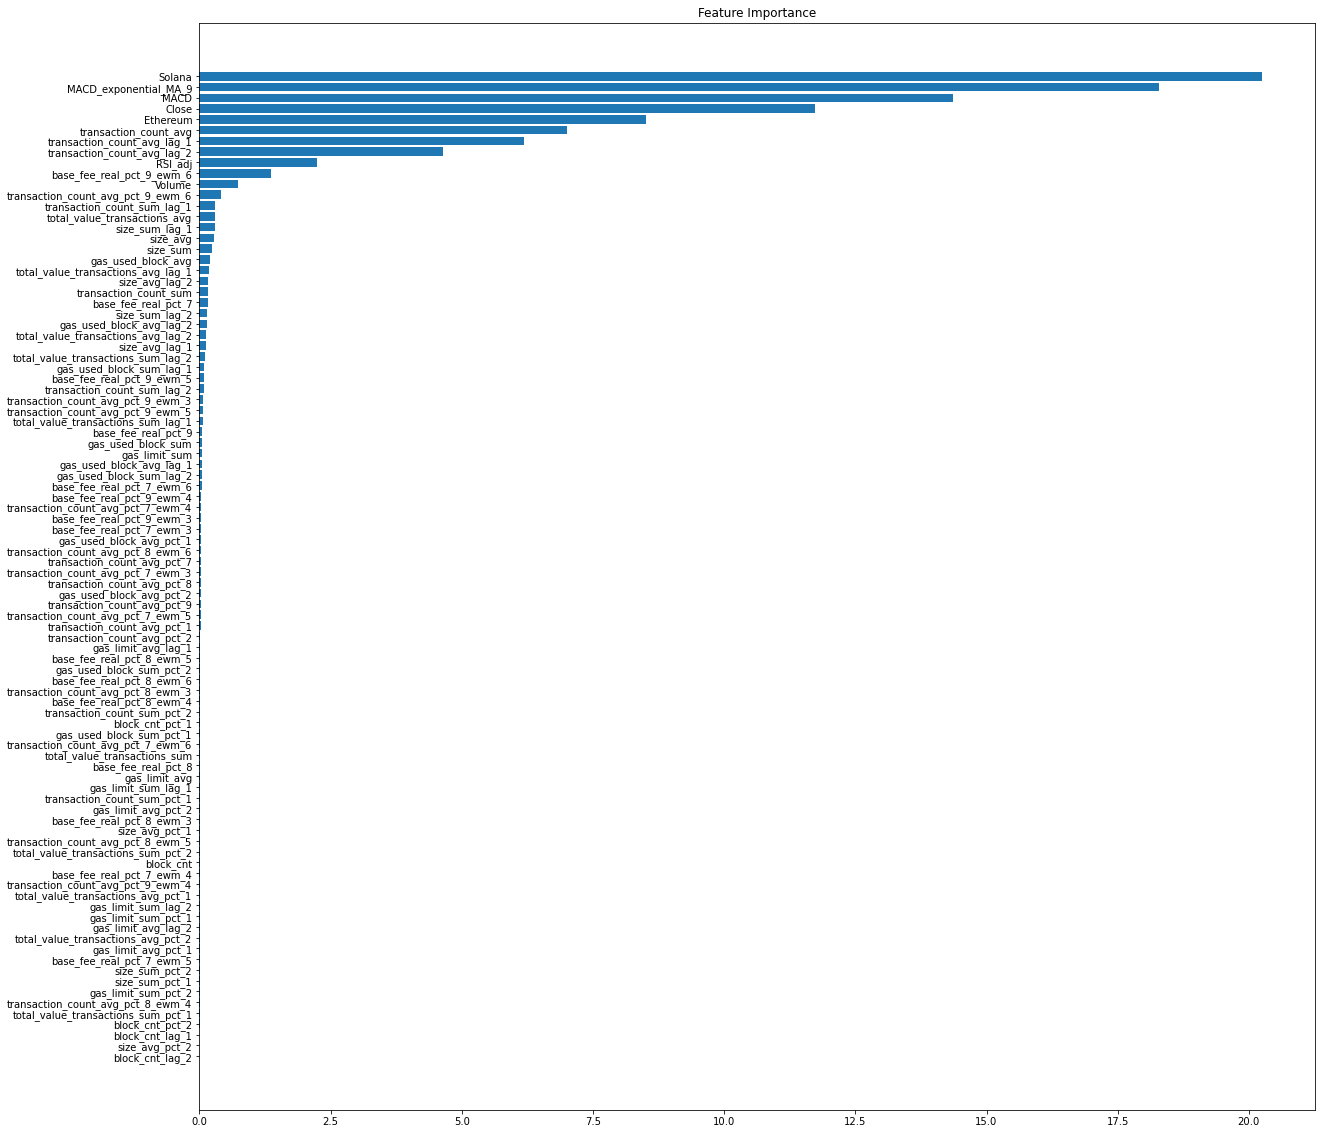

In [8]:

feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
fig = plt.figure(figsize=(20, 20))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), np.array(X.columns)[sorted_idx])
plt.title('Feature Importance')


In [9]:
vars_selected = []

for i in range(25):
    cur_var_index = sorted_idx[len(var_pool) - 1 - i]
    vars_selected.append(var_pool[cur_var_index])

In [10]:
vars_selected

['Solana',
 'MACD_exponential_MA_9',
 'MACD',
 'Close',
 'Ethereum',
 'transaction_count_avg',
 'transaction_count_avg_lag_1',
 'transaction_count_avg_lag_2',
 'RSI_adj',
 'base_fee_real_pct_9_ewm_6',
 'Volume',
 'transaction_count_avg_pct_9_ewm_6',
 'transaction_count_sum_lag_1',
 'total_value_transactions_avg',
 'size_sum_lag_1',
 'size_avg',
 'size_sum',
 'gas_used_block_avg',
 'total_value_transactions_avg_lag_1',
 'size_avg_lag_2',
 'transaction_count_sum',
 'base_fee_real_pct_7',
 'size_sum_lag_2',
 'gas_used_block_avg_lag_2',
 'total_value_transactions_avg_lag_2']

In [23]:
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

cbr_hyper_rmse_r2_list = []
# cbr_rmse_list = []
rf_rmse_list = []
gbr_rmse_list = []
cbr_r2_list = []

df = df_fe.copy().dropna(subset='base_fee_real')

start_time = time()
for d in [4,5,6]:
    for cbr_iter in np.arange(250,660,50):
    # for cbr_iter in [500]:
        for niter in range(5):
        # for niter in [0]:
            tmp_time = time()
            print('----- working on d %d, cbr_iter %d, niter %d -----'%(d, cbr_iter, niter))
            oot = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=0+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=1+niter)))]
            tst = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=1+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=3+niter)))]
            trn = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=3+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=12+niter)))]

            x_trn = trn[vars_selected]
            x_tst = tst[vars_selected]
            x_oot = oot[vars_selected]

            ############################################################
            # preprocessing
            # winsorization
            trn_pctil_95 = x_trn[vars_selected].quantile(0.95)
            trn_pctil_10 = x_trn[vars_selected].quantile(0.1)

            x_tst = x_tst.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
            x_oot = x_oot.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
            x_trn = x_trn.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)

            # Normalization and standardize to [-1,1]
            x_tst = (x_tst - x_trn.mean()) / x_trn.std()
            x_tst = 2 * (x_tst - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

            x_oot = (x_oot - x_trn.mean()) / x_trn.std()
            x_oot = 2 * (x_oot - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

            x_trn = (x_trn - x_trn.mean()) / x_trn.std()
            x_trn = 2 * (x_trn - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

            # impute for missing values
            x_tst.fillna(x_trn.mean(),inplace=True)
            x_oot.fillna(x_trn.mean(),inplace=True)
            x_trn.fillna(x_trn.mean(),inplace=True)
                        
            # print('working on knn imputer')
            # # KNN imputation is taking too much time, ignore for now
            # imputer = KNNImputer(n_neighbors=3)
            # imputer.fit(x_trn)

            # x_trn = imputer.transform(x_trn)
            # x_tst = imputer.transform(x_tst)
            # x_oot = imputer.transform(x_oot)
        ############################################################
            print('Preprocessing Finished')
            y_oot = oot['base_fee_real']
            y_tst = tst['base_fee_real']
            y_trn = trn['base_fee_real']

            # rf = RandomForestRegressor(n_estimators=100, criterion='gini', max_depth=15, min_samples_split=20, min_samples_leaf=200, max_features='log2')
            cbr = CatBoostRegressor(verbose=0, depth=d, iterations=cbr_iter, learning_rate=0.01, l2_leaf_reg=5, random_seed=42)
            cbr.fit(x_trn, y_trn)

            cbr_predictions_trn = cbr.predict(x_trn)
            rmse_trn = np.sqrt(mean_squared_error(y_trn, cbr_predictions_trn))

            cbr_predictions_tst = cbr.predict(x_tst)
            rmse_tst = np.sqrt(mean_squared_error(y_tst, cbr_predictions_tst))

            cbr_predictions_oot = cbr.predict(x_oot)
            rmse_oot = np.sqrt(mean_squared_error(y_oot, cbr_predictions_oot))
            cbr_hyper_rmse_r2_list.append([cbr_iter, d, rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
            print('cbr finished')
            

----- working on d 4, cbr_iter 250, niter 0 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 250, niter 1 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 250, niter 2 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 250, niter 3 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 250, niter 4 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 300, niter 0 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 300, niter 1 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 300, niter 2 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 300, niter 3 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 300, niter 4 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 350, niter 0 -----
Preprocessing Finished
cbr finished
----- working on d 4, cbr_iter 350, niter 1 -----
Prep

In [24]:
cbr_hyper_rmse_r2_df = pd.DataFrame(cbr_hyper_rmse_r2_list, columns=['cbr_iter','d','trn_rmse','tst_rmse','oot_rmse','trn_r2'])
cbr_hyper_rmse_r2_df

,cbr_iter,d,trn_rmse,tst_rmse,oot_rmse,trn_r2
0,250,4,1.769620e+10,2.428587e+10,1.373601e+10,0.447670
1,250,4,1.805965e+10,1.635015e+10,2.666341e+10,0.406163
2,250,4,1.794138e+10,1.194279e+10,2.055607e+10,0.403501
3,250,4,1.808094e+10,1.353843e+10,1.169721e+10,0.421547
4,250,4,1.741630e+10,1.540555e+10,1.275137e+10,0.464374
...,...,...,...,...,...,...
130,650,6,1.368026e+10,2.615027e+10,1.484727e+10,0.669914
131,650,6,1.379860e+10,1.701483e+10,2.867604e+10,0.653328
132,650,6,1.335303e+10,1.141763e+10,2.191527e+10,0.669586
133,650,6,1.357246e+10,1.374185e+10,1.071165e+10,0.674056


In [26]:
cbr_hyper_rmse_r2_df.to_csv('min_level_cbr_hyper_rmse_r2_df.csv')

In [28]:
cbr_hyper_rmse_r2_df.groupby(['cbr_iter', 'd']).mean()

trn_rmse      tst_rmse      oot_rmse    trn_r2
cbr_iter d                                                    
250      4  1.783889e+10  1.630456e+10  1.708081e+10  0.428651
         5  1.703271e+10  1.615744e+10  1.698101e+10  0.479158
         6  1.622555e+10  1.625253e+10  1.704537e+10  0.527409
300      4  1.745392e+10  1.644340e+10  1.718494e+10  0.453086
         5  1.660425e+10  1.631684e+10  1.712501e+10  0.505005
         6  1.577386e+10  1.643366e+10  1.718918e+10  0.553317
350      4  1.711536e+10  1.660447e+10  1.728567e+10  0.474121
         5  1.623449e+10  1.644777e+10  1.721648e+10  0.526816
         6  1.536418e+10  1.662538e+10  1.735241e+10  0.576178
400      4  1.681777e+10  1.677577e+10  1.740116e+10  0.492263
         5  1.592322e+10  1.661006e+10  1.732147e+10  0.544774
         6  1.501230e+10  1.675818e+10  1.742687e+10  0.595370
450      4  1.655348e+10  1.690532e+10  1.750579e+10  0.508144
         5  1.559423e+10  1.674019e+10  1.739889e+10  0.563446
         6  1.468833e+10  1.688273e+10  1.754997e+10  0.612656
500      4  1.627539e+10  1.701834e+10  1.755617e+10  0.524573
         5  1.527622e+10  1.685223e+10  1.745808e+10  0.581128
         6  1.435298e+10  1.695417e+10  1.760875e+10  0.630168
550      4  1.600244e+10  1.707706e+10  1.759805e+10  0.540396
         5  1.498087e+10  1.687636e+10  1.747612e+10  0.597201
         6  1.405871e+10  1.697173e+10  1.763772e+10  0.645214
600      4  1.575202e+10  1.715485e+10  1.766475e+10  0.554673
         5  1.470243e+10  1.687516e+10  1.750887e+10  0.612053
         6  1.378323e+10  1.699159e+10  1.766640e+10  0.658988
650      4  1.551493e+10  1.717210e+10  1.769189e+10  0.567983
         5  1.444082e+10  1.688062e+10  1.751671e+10  0.625744
         6  1.353338e+10  1.698434e+10  1.765781e+10  0.671256

# The main code ends here.

# Some Explorations and Thoughts

In [7]:
df_min.corr()['base_fee_real'].apply(lambda x: abs(x)).sort_values()

size_avg                        0.002092
Volume                          0.007234
gas_limit_avg                   0.009342
transaction_count_sum           0.010562
size_sum                        0.013960
total_value_transactions_sum    0.014554
total_value_transactions_avg    0.016015
gas_used_block_sum              0.019556
gas_used_block_avg              0.026684
RSI_adj                         0.030658
gas_limit_sum                   0.036591
block_cnt                       0.036609
transaction_count_avg           0.041277
MACD_exponential_MA_9           0.061530
MACD                            0.064849
Solana                          0.093747
Close                           0.107557
Ethereum                        0.125700
base_fee_real                   1.000000
Name: base_fee_real, dtype: float64

In [10]:
df_copy = df_min.copy()
corr_list = ['base_fee_real']
for col in ['total_value_transactions_sum', 'size_sum', 'gas_limit_sum',
       'transaction_count_sum', 'gas_used_block_sum', 'block_cnt',
       'total_value_transactions_avg', 'size_avg', 'gas_limit_avg',
       'transaction_count_avg', 'gas_used_block_avg']:
   for i in range(1,3):
      df_copy[col + '_pct_' + str(i)] = df_copy[col].pct_change(i)
      df_copy[col + '_lag_' + str(i)] = df_copy[col].shift(i)
      corr_list.append(col + '_pct_' + str(i))
      corr_list.append(col + '_lag_' + str(i))

df_copy_corr = df_copy[corr_list].corr()['base_fee_real'].apply(lambda x: abs(x)).sort_values(ascending=False)
df_copy_corr

base_fee_real                         1.000000
transaction_count_avg_lag_1           0.039421
transaction_count_avg_lag_2           0.037484
block_cnt_lag_1                       0.032158
gas_limit_sum_lag_1                   0.032141
block_cnt_lag_2                       0.028708
gas_limit_sum_lag_2                   0.028691
gas_used_block_avg_lag_1              0.025530
gas_used_block_avg_lag_2              0.024317
gas_used_block_sum_lag_1              0.015747
total_value_transactions_avg_lag_1    0.015630
total_value_transactions_avg_lag_2    0.015392
total_value_transactions_sum_lag_2    0.014583
total_value_transactions_sum_lag_1    0.014537
transaction_count_sum_lag_2           0.013922
size_sum_lag_1                        0.013912
size_sum_lag_2                        0.013568
gas_used_block_sum_lag_2              0.012980
transaction_count_sum_lag_1           0.012628
block_cnt_pct_1                       0.012064
gas_limit_sum_pct_1                   0.012063
block_cnt_pct

In [11]:
df_copy = df_min.copy()
corr_list = ['base_fee_real']

for i in range(1, 10):
  df_copy['gas_used_block_sum_' + str(i)] = df_copy['gas_used_block_sum'].pct_change(i)
  for j in range(3,7):
    df_copy['gas_used_block_sum_' + str(i) + '_ewm_' + str(j)] = df_copy['gas_used_block_sum_' + str(i)].ewm(span=j, adjust=False).mean()
    corr_list.append('gas_used_block_sum_' + str(i) + '_ewm_' + str(j))
  corr_list.append('gas_used_block_sum_' + str(i))

df_copy_corr = df_copy[corr_list].corr()['base_fee_real'].apply(lambda x: abs(x)).sort_values(ascending=False)
df_copy_corr

base_fee_real                 1.000000
gas_used_block_sum_6_ewm_6    0.022220
gas_used_block_sum_1_ewm_6    0.021859
gas_used_block_sum_3_ewm_6    0.021804
gas_used_block_sum_8_ewm_6    0.021042
gas_used_block_sum_4_ewm_6    0.020649
gas_used_block_sum_2_ewm_6    0.020514
gas_used_block_sum_1_ewm_5    0.020005
gas_used_block_sum_6_ewm_5    0.019890
gas_used_block_sum_3_ewm_5    0.019621
gas_used_block_sum_5_ewm_6    0.019194
gas_used_block_sum_7_ewm_6    0.018946
gas_used_block_sum_8_ewm_5    0.018810
gas_used_block_sum_4_ewm_5    0.018561
gas_used_block_sum_2_ewm_5    0.018535
gas_used_block_sum_1_ewm_4    0.017895
gas_used_block_sum_6_ewm_4    0.017351
gas_used_block_sum_3_ewm_4    0.017206
gas_used_block_sum_5_ewm_5    0.017127
gas_used_block_sum_7_ewm_5    0.016854
gas_used_block_sum_8_ewm_4    0.016381
gas_used_block_sum_2_ewm_4    0.016330
gas_used_block_sum_4_ewm_4    0.016271
gas_used_block_sum_9_ewm_6    0.016042
gas_used_block_sum_1_ewm_3    0.015432
gas_used_block_sum_5_ewm_

In [12]:
df_copy = df_min.copy()
corr_list = ['base_fee_real']

for i in range(1, 10):
  df_copy['base_fee_real_pct_' + str(i)] = df_copy['base_fee_real'].pct_change(i)
  for j in range(3,7):
    df_copy['base_fee_real_pct_' + str(i) + '_ewm_' + str(j)] = df_copy['base_fee_real_pct_' + str(i)].ewm(span=j, adjust=False).mean()
    corr_list.append('base_fee_real_pct_' + str(i) + '_ewm_' + str(j))
  corr_list.append('base_fee_real_pct_' + str(i))

df_copy_corr = df_copy[corr_list].corr()['base_fee_real'].apply(lambda x: abs(x)).sort_values(ascending=False)
df_copy_corr

base_fee_real                1.000000
base_fee_real_pct_9_ewm_6    0.130468
base_fee_real_pct_9_ewm_5    0.126604
base_fee_real_pct_9_ewm_4    0.122699
base_fee_real_pct_8_ewm_6    0.119046
base_fee_real_pct_9_ewm_3    0.118730
base_fee_real_pct_8_ewm_5    0.115112
base_fee_real_pct_8_ewm_4    0.111058
base_fee_real_pct_9          0.109213
base_fee_real_pct_7_ewm_6    0.106877
base_fee_real_pct_8_ewm_3    0.106847
base_fee_real_pct_7_ewm_5    0.102930
base_fee_real_pct_7_ewm_4    0.098786
base_fee_real_pct_8          0.096607
base_fee_real_pct_6_ewm_6    0.095878
base_fee_real_pct_7_ewm_3    0.094401
base_fee_real_pct_6_ewm_5    0.091928
base_fee_real_pct_6_ewm_4    0.087714
base_fee_real_pct_5_ewm_6    0.086849
base_fee_real_pct_7          0.083785
base_fee_real_pct_6_ewm_3    0.083191
base_fee_real_pct_5_ewm_5    0.082842
base_fee_real_pct_4_ewm_6    0.078856
base_fee_real_pct_5_ewm_4    0.078505
base_fee_real_pct_4_ewm_5    0.074730
base_fee_real_pct_5_ewm_3    0.073782
base_fee_rea

In [53]:
df_copy_corr[df_copy_corr >= 0.1]

base_fee_real_pct_7_ewm_5    0.102930
base_fee_real_pct_8_ewm_3    0.106847
base_fee_real_pct_7_ewm_6    0.106877
base_fee_real_pct_9          0.109213
base_fee_real_pct_8_ewm_4    0.111058
base_fee_real_pct_8_ewm_5    0.115112
base_fee_real_pct_9_ewm_3    0.118729
base_fee_real_pct_8_ewm_6    0.119047
base_fee_real_pct_9_ewm_4    0.122699
base_fee_real_pct_9_ewm_5    0.126604
base_fee_real_pct_9_ewm_6    0.130467
base_fee_real                1.000000
Name: base_fee_real, dtype: float64

In [18]:
df_min.columns

Index(['datetime', 'total_value_transactions_sum', 'size_sum', 'gas_limit_sum',
       'transaction_count_sum', 'gas_used_block_sum', 'block_cnt',
       'total_value_transactions_avg', 'size_avg', 'gas_limit_avg',
       'transaction_count_avg', 'gas_used_block_avg', 'Volume', 'Close',
       'RSI_adj', 'MACD', 'MACD_exponential_MA_9', 'Ethereum', 'Solana',
       'base_fee_real'],
      dtype='object')

In [61]:
variables = ['total_value_transactions_sum', 'size_sum', 'gas_limit_sum',
       'transaction_count_sum', 'gas_used_block_sum', 'block_cnt',
       'total_value_transactions_avg', 'size_avg', 'gas_limit_avg',
       'transaction_count_avg', 'gas_used_block_avg', 'Volume', 'Close',
       'RSI_adj', 'MACD', 'MACD_exponential_MA_9', 'Ethereum', 'Solana']
df = df_min.copy()

In [62]:
for j in [3,4,5,6]:
    df['base_fee_real_pct_9_ewm_' + str(j)] = df['base_fee_real'].pct_change(9).ewm(span=j, adjust=False).mean()
    df['base_fee_real_pct_8_ewm_' + str(j)] = df['base_fee_real'].pct_change(8).ewm(span=j, adjust=False).mean()

df['base_fee_real_pct_9'] = df['base_fee_real'].pct_change(9)


In [63]:
variables = ['total_value_transactions_sum', 'size_sum', 'gas_limit_sum',
       'transaction_count_sum', 'gas_used_block_sum', 'block_cnt',
       'total_value_transactions_avg', 'size_avg', 'gas_limit_avg',
       'transaction_count_avg', 'gas_used_block_avg', 'Volume', 'Close',
       'RSI_adj', 'MACD', 'MACD_exponential_MA_9', 'Ethereum', 'Solana','base_fee_real_pct_9_ewm_3',
       'base_fee_real_pct_8_ewm_3', 'base_fee_real_pct_9_ewm_4',
       'base_fee_real_pct_8_ewm_4', 'base_fee_real_pct_9_ewm_5',
       'base_fee_real_pct_8_ewm_5', 'base_fee_real_pct_9_ewm_6',
       'base_fee_real_pct_8_ewm_6', 'base_fee_real_pct_9']

In [64]:
df[variables]

,total_value_transactions_sum,size_sum,gas_limit_sum,transaction_count_sum,gas_used_block_sum,block_cnt,total_value_transactions_avg,size_avg,gas_limit_avg,transaction_count_avg,...,Solana,base_fee_real_pct_9_ewm_3,base_fee_real_pct_8_ewm_3,base_fee_real_pct_9_ewm_4,base_fee_real_pct_8_ewm_4,base_fee_real_pct_9_ewm_5,base_fee_real_pct_8_ewm_5,base_fee_real_pct_9_ewm_6,base_fee_real_pct_8_ewm_6,base_fee_real_pct_9
0,7.746915e+20,468531,150117209,1170,95738481,5,1.549383e+20,93706.20,3.002344e+07,234.000000,...,4.024894e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5.315025e+20,259546,120234361,707,62605144,4,1.328756e+20,64886.50,3.005859e+07,176.750000,...,4.024894e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5.534524e+20,498339,179941352,1027,94497699,6,9.224206e+19,83056.50,2.999023e+07,171.166667,...,4.024894e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2.128304e+21,510549,120058419,965,87369874,4,5.320761e+20,127637.25,3.001460e+07,241.250000,...,4.024894e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1.861651e+20,167212,30087915,326,30084193,1,1.861651e+20,167212.00,3.008792e+07,326.000000,...,4.024894e+09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952869,2.954305e+20,773349,150000000,589,65352786,5,5.908609e+19,154669.80,3.000000e+07,117.800000,...,1.567440e+09,-0.010834,0.011407,-0.010691,0.010208,-0.014152,0.006178,-0.019440,0.000588,-0.028214
952870,3.186089e+20,2602240,150000000,562,83828342,5,6.372179e+19,520448.00,3.000000e+07,112.400000,...,1.567440e+09,0.016519,0.015092,0.011134,0.013635,0.005189,0.010377,-0.001351,0.005785,0.043871
952871,4.249720e+20,728055,120000000,767,74170918,4,1.062430e+20,182013.75,3.000000e+07,191.750000,...,1.567440e+09,-0.004907,-0.021075,-0.003853,-0.014716,-0.005318,-0.012162,-0.008488,-0.012223,-0.026332
952872,2.371840e+20,1462799,150000000,578,70052018,5,4.743680e+19,292559.80,3.000000e+07,115.600000,...,1.567440e+09,0.021478,0.005011,0.016834,0.003609,0.012409,0.002257,0.007612,0.000154,0.047863


In [74]:
from dateutil.relativedelta import relativedelta

from sklearn.metrics import mean_squared_error
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb
from sklearn.impute import KNNImputer

cbr_hyper_rmse_r2_list = []
# cbr_rmse_list = []
rf_rmse_list = []
gbr_rmse_list = []
cbr_r2_list = []

start_time = time()
for cbr_iter in np.arange(350,701,50):
# for cbr_iter in [400]:
    cbr_rmse_list = []
    print('########## working on cbr_iter %d ##########'%cbr_iter)
    for niter in range(5):
        tmp_time = time()
        print('----- working on cbr_iter %d, niter %d -----'%(cbr_iter,niter))
        oot = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=0+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=1+niter)))]
        tst = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=1+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=3+niter)))]
        trn = df[(df['datetime'] <= (df['datetime'].max() - relativedelta(months=3+niter))) & (df['datetime'] > (df['datetime'].max() - relativedelta(months=12+niter)))]

        x_trn = trn[variables]
        x_tst = tst[variables]
        x_oot = oot[variables]

    ############################################################
        # preprocessing
        # winsorization
        trn_pctil_95 = x_trn[variables].quantile(0.95)
        trn_pctil_10 = x_trn[variables].quantile(0.1)

        x_tst = x_tst.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
        x_oot = x_oot.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)
        x_trn = x_trn.clip(lower=trn_pctil_10, upper=trn_pctil_95, axis=1)

        # Normalization and standardize to [-1,1]
        x_tst = (x_tst - x_trn.mean()) / x_trn.std()
        x_tst = 2 * (x_tst - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

        x_oot = (x_oot - x_trn.mean()) / x_trn.std()
        x_oot = 2 * (x_oot - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

        x_trn = (x_trn - x_trn.mean()) / x_trn.std()
        x_trn = 2 * (x_trn - x_trn.min()) / (x_trn.max() - x_trn.min()) - 1

        # impute for missing values
        x_tst.fillna(x_trn.mean())
        x_oot.fillna(x_trn.mean())
        x_trn.fillna(x_trn.mean())
        
        # print('working on knn imputer')
        # # KNN imputation is taking too much time, ignore for now
        # imputer = KNNImputer(n_neighbors=3)
        # imputer.fit(x_trn)
        
        # x_trn = imputer.transform(x_trn)
        # x_tst = imputer.transform(x_tst)
        # x_oot = imputer.transform(x_oot)
    ############################################################
        print('Preprocessing Finished')
        y_oot = oot['base_fee_real']
        y_tst = tst['base_fee_real']
        y_trn = trn['base_fee_real']

        # rf = RandomForestRegressor(n_estimators=100, criterion='gini', max_depth=15, min_samples_split=20, min_samples_leaf=200, max_features='log2')
        cbr = CatBoostRegressor(verbose=0, depth=8, iterations=cbr_iter, learning_rate=0.01, l2_leaf_reg=5, random_seed=42)
        cbr.fit(x_trn, y_trn)

        cbr_predictions_trn = cbr.predict(x_trn)
        rmse_trn = np.sqrt(mean_squared_error(y_trn, cbr_predictions_trn))

        cbr_predictions_tst = cbr.predict(x_tst)
        rmse_tst = np.sqrt(mean_squared_error(y_tst, cbr_predictions_tst))

        cbr_predictions_oot = cbr.predict(x_oot)
        rmse_oot = np.sqrt(mean_squared_error(y_oot, cbr_predictions_oot))
        # cbr_rmse_list.append([rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
        cbr_hyper_rmse_r2_list.append([cbr_iter, rmse_trn, rmse_tst, rmse_oot, cbr.score(x_trn, y_trn)])
        print('cbr finished')
        

        # rf.fit(x_trn, y_trn)
        # rf_predictions_trn = cbr.predict(x_trn)
        # rmse_trn = np.sqrt(mean_squared_error(y_trn, rf_predictions_trn))

        # rf_predictions_tst = cbr.predict(x_tst)
        # rmse_tst = np.sqrt(mean_squared_error(y_tst, rf_predictions_trn))

        # rf_predictions_oot = cbr.predict(x_oot)
        # rmse_oot = np.sqrt(mean_squared_error(y_oot, rf_predictions_trn))
        # rf_rmse_list.append([rmse_trn, rmse_tst, rmse_oot])

########## working on cbr_iter 350 ##########
----- working on niter 0 -----
Preprocessing Finished
cbr finished
----- working on niter 1 -----
Preprocessing Finished
cbr finished
----- working on niter 2 -----
Preprocessing Finished
cbr finished
----- working on niter 3 -----
Preprocessing Finished
cbr finished
----- working on niter 4 -----
Preprocessing Finished
cbr finished
########## working on cbr_iter 400 ##########
----- working on niter 0 -----
Preprocessing Finished
cbr finished
----- working on niter 1 -----
Preprocessing Finished
cbr finished
----- working on niter 2 -----
Preprocessing Finished
cbr finished
----- working on niter 3 -----
Preprocessing Finished
cbr finished
----- working on niter 4 -----
Preprocessing Finished
cbr finished
########## working on cbr_iter 450 ##########
----- working on niter 0 -----
Preprocessing Finished
cbr finished
----- working on niter 1 -----
Preprocessing Finished
cbr finished
----- working on niter 2 -----
Preprocessing Finished
cbr 

In [75]:
cbr_hyper_rmse_r2_df = pd.DataFrame(cbr_hyper_rmse_r2_list, columns=['cbr_iter','trn_rmse','tst_rmse','oot_rmse','trn_r2'])
cbr_hyper_rmse_r2_df

,cbr_iter,trn_rmse,tst_rmse,oot_rmse,trn_r2
0,350,1.383454e+10,2.181646e+10,1.330643e+10,0.662427
1,350,1.398107e+10,1.661295e+10,2.705973e+10,0.644098
2,350,1.347739e+10,1.227644e+10,2.043733e+10,0.663404
3,350,1.369288e+10,1.369701e+10,1.185615e+10,0.668246
4,350,1.337037e+10,1.591350e+10,1.268253e+10,0.684328
5,400,1.343706e+10,2.187184e+10,1.332368e+10,0.681546
6,400,1.358867e+10,1.663410e+10,2.711526e+10,0.663796
7,400,1.309940e+10,1.225372e+10,2.049937e+10,0.682019
8,400,1.327877e+10,1.369857e+10,1.182239e+10,0.688009
9,400,1.294894e+10,1.594373e+10,1.266445e+10,0.703914


In [77]:
cbr_hyper_rmse_r2_df.groupby('cbr_iter').mean()

,trn_rmse,tst_rmse,oot_rmse,trn_r2
cbr_iter,,,,
350,1.367125e+10,1.606327e+10,1.706843e+10,0.664501
400,1.327057e+10,1.608039e+10,1.708503e+10,0.683857
450,1.292581e+10,1.604631e+10,1.708762e+10,0.700061
500,1.261297e+10,1.601573e+10,1.709242e+10,0.714407
550,1.234143e+10,1.600636e+10,1.707533e+10,0.726581
600,1.209748e+10,1.598197e+10,1.709035e+10,0.737276
650,1.186258e+10,1.598267e+10,1.707440e+10,0.747376
700,1.163431e+10,1.606483e+10,1.699976e+10,0.757003
